# XGBoost for PLT Reduction Prediction

## Task
- Binary classification
- Target: PLT reduction (0 = normal, 1 = medium, 2 = severe)

## Model
- XGBoost Classifier (xgboost)

## Metrics
- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC

## Notes
This notebook serves as the comparison model.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold, LeaveOneOut
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

TARGET_COL = "PLT 严重程度分组"
DATA_PATH = "../data/PLTdataset.xlsx"
SHEET_NAME = "血小板减少预测"

In [3]:
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)

print("Data shape:", df.shape)
df.head()

Data shape: (63, 36)


,样本名称,"PLT count(0,>100,1,<100)",PLT 减少事件分组,PLT 严重程度分组,Gender（女，0；男，1）,动脉血栓（有1，无0）,"FHb(1,>40mg/L;0,<40mg/L)","FHb(1,>40mg/L;0,<40mg/L).1",LDH,"RDW1(0<15%,1≥15%",...,WBC,NC,STO,FIB,D dimer,NO,CHO,LDL,Pla(脂蛋白a),SOD
0,N1,135.0,0.0,0.0,0.0,0.0,19.974734,0.0,237.0,13.7,...,5.90,3.14,25.2,2.13,8.26,28.5,4.28,1.88,0.55,72.0
1,N10,143.0,0.0,0.0,1.0,1.0,20.367691,0.0,273.0,15.0,...,5.50,3.50,18.0,2.30,0.39,49.0,3.17,1.39,0.10,45.0
2,N11,116.0,0.0,0.0,1.0,1.0,49.988801,1.0,167.0,15.2,...,10.21,7.12,5.0,2.38,25.17,34.5,3.70,2.24,0.10,101.0
3,N12,156.0,0.0,0.0,1.0,0.0,14.744621,0.0,216.0,15.0,...,4.21,2.98,5.0,2.30,0.66,30.0,7.82,3.94,0.31,90.0
4,N13,138.0,0.0,0.0,1.0,0.0,15.565815,0.0,125.0,14.7,...,6.90,4.76,5.0,2.42,0.73,35.5,3.48,1.66,0.15,133.0


In [4]:
df.info()

df[TARGET_COL].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   样本名称                                       62 non-null     object 
 1   PLT count(0,>100,1,<100)                   62 non-null     float64
 2   PLT 减少事件分组                                 62 non-null     float64
 3   PLT 严重程度分组                                 62 non-null     float64
 4   Gender（女，0；男，1）                            62 non-null     float64
 5   动脉血栓（有1，无0）                                62 non-null     float64
 6   FHb(1,>40mg/L;0,<40mg/L)                   62 non-null     float64
 7   FHb(1,>40mg/L;0,<40mg/L).1                 62 non-null     float64
 8   LDH                                        62 non-null     float64
 9   RDW1(0<15%,1≥15%                           62 non-null     float64
 10  RDW1(0<15%,1≥15%.1          

PLT 严重程度分组
0.0    0.516129
1.0    0.370968
2.0    0.112903
Name: proportion, dtype: float64

In [5]:
DROP_COLS = ["样本名称", "PLT count(0,>100,1,<100)", "PLT 减少事件分组", "Gender（女，0；男，1）", "动脉血栓（有1，无0）", "FHb(1,>40mg/L;0,<40mg/L).1", "TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL).1", "PLA2（0<659IU/L,1≥659IU/L）.1", " HGB（1<100mg/L,2≥100mg/L）", "MCV(0<100fL,1≥100mfL).1", "RDW1(0<15%,1≥15%.1", "HDL（0≥0.8mmol/L,1<0.8mmol/L）.1", "FVIII(0.<120;1,>120%).1", TARGET_COL]
X = df.drop(columns=DROP_COLS)
y = df[TARGET_COL]

In [6]:
print("Missing values:")
print(X.isna().sum().sort_values(ascending=False))

X = X.dropna()
y = y.loc[X.index]
y = y.astype(int)  # 多分类强制转换为整数类型
X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)
print("Feature shape after encoding:", X.shape)

Missing values:
FHb(1,>40mg/L;0,<40mg/L)                   1
LDH                                        1
Pla(脂蛋白a)                                  1
LDL                                        1
CHO                                        1
NO                                         1
D dimer                                    1
FIB                                        1
STO                                        1
NC                                         1
WBC                                        1
Age                                        1
FVIII(0.<120;1,>120%)                      1
HDL（0≥0.8mmol/L,1<0.8mmol/L）               1
 HGB（1<100mg/L,0≥100mg/L）                  1
PLA2（0<659IU/L,1≥659IU/L）                  1
脾大（1,是，0否）                                 1
CRP                                        1
TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL)    1
RDW1(0<15%,1≥15%                           1
SOD                                        1
MCV(0<100fL,1≥100mfL)                  

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size=TEST_SIZE,
#     random_state=RANDOM_STATE,
#     stratify=y
# )

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# print("Train:", X_train.shape)
# print("Test:", X_test.shape)

Train: (49, 22)
Test: (13, 22)


In [8]:
# model = XGBClassifier(
#     n_estimators=200,
#     max_depth=3,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective="multi:softprob",  # 修改目标函数为多分类概率
#     num_class=3,                 # 必须指定类别数量
#     eval_metric="mlogloss",      # 修改评估指标为多分类对数损失
#     random_state=RANDOM_STATE
# )

In [9]:
# model.fit(X_train, y_train)

xgb_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('xgb', XGBClassifier(
        eval_metric="logloss", 
        use_label_encoder=False, 
        random_state=42
    ))
])

param_grid_xgb = {
    'xgb__max_depth': [1, 2, 3],       # 小样本树要浅
    'xgb__n_estimators': [5, 10, 20, 50], # 树的数量
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__reg_alpha': [0, 0.1, 1],     # L1 正则化抗过拟合
    'xgb__subsample': [0.8, 1.0]       # 每次训练随机抽样比例
}

cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid_xgb,
    cv=cv_5fold,
    scoring='f1',
    n_jobs=1
)
grid_search.fit(X, y)
model = grid_search.best_estimator_
print("5-Fold 最佳 F1:", grid_search.best_score_)
print("5-Fold 最佳参数:", grid_search.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [10]:
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test) # 不要加 [:, 1]

loo = LeaveOneOut()

y_probas_loo = cross_val_predict(model, X, y, cv=loo, method='predict_proba')
# 使用 argmax 选出概率最大的类别
y_preds_loo = np.argmax(y_probas_loo, axis=1)

In [11]:
# 多分类指标计算
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='weighted'), # 必须加 average
    "recall": recall_score(y_test, y_pred, average='macro'),       # 必须加 average
    "f1": f1_score(y_test, y_pred, average='weighted'),               # 必须加 average
    # ROC_AUC 需要概率矩阵，且指定多分类策略
    "roc_auc": roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted'), 
    # PR_AUC 在多分类中通常不直接支持，需要二值化标签或移除，这里建议暂时移除或仅看 F1
}

metrics_df = pd.DataFrame(metrics, index=["XGBoost"])
metrics_df

/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,f1,roc_auc
XGBoost,0.923077,0.858974,0.666667,0.888112,0.974359


In [12]:
# fpr, tpr, _ = roc_curve(y_test, y_prob)

# plt.figure()
# plt.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.3f}")
# plt.plot([0, 1], [0, 1], "k--")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve - XGBoost")
# plt.legend()
# plt.show()

In [13]:
# precision, recall, _ = precision_recall_curve(y_test, y_prob)

# plt.figure()
# plt.plot(recall, precision, label=f"AP = {metrics['pr_auc']:.3f}")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve - XGBoost")
# plt.legend()
# plt.show()

/tmp/ipykernel_844/274319585.py:10: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_844/274319585.py:10: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_844/274319585.py:10: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_844/274319585.py:10: UserWarning: Glyph 33539 (\N{CJK UNIFIED IDEOGRAPH-8303}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_844/274319585.py:10: UserWarning: Glyph 22260 (\N{CJK UNIFIED IDEOGRAPH-56F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_844/274319585.py:10: UserWarning: Glyph 33026 (\N{CJK UNIFIED IDEOGRAPH-8102}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_844/274319585.py:10: UserWarning: Glyph 34507 (\N{CJK UNIFIED IDEOGRAPH-86CB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_84

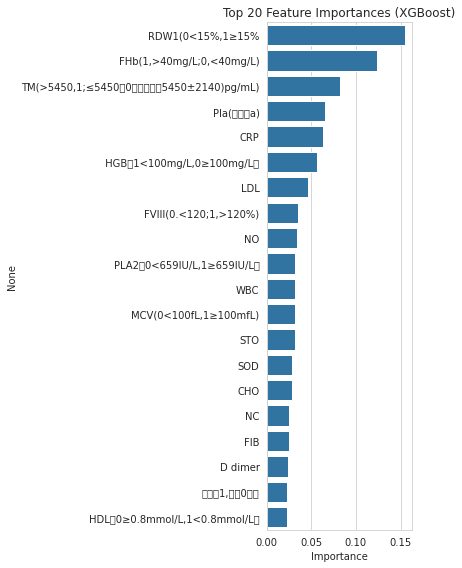

In [14]:
feat_imp = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(6, 8))
sns.barplot(x=feat_imp.head(20), y=feat_imp.head(20).index)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:")
print(feat_imp.head(10))

In [15]:
metrics_df.to_csv("../outputs/xgb_metrics_02.csv")
feat_imp.to_csv("../outputs/xgb_feature_importance_02.csv")

plt.savefig("../outputs/xgb_feature_importance_02.png", dpi=300)

<Figure size 432x288 with 0 Axes>

## Summary

- Random Forest baseline completed
- PR-AUC suggests model performance under class imbalance
- Top features identified for further analysis

Next steps:
- XGBoost
- LightGBM
- Threshold tuning